Based on this paper https://doi.org/10.1088/2634-4386/ac1b75

In [2]:
import sys
sys.path.append('/import/silo2/aloe8475/Documents/edamame')

In [3]:
from scipy.io import loadmat, savemat
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors
import networkx as nx
from edamame import *
from tqdm import tqdm_notebook as tqdm
import os
import edamame.core.wires as wires
from random import choice
from IPython.core.debugger import set_trace
import pickle 
import _pickle as cPickle
import gzip

def compressed_pickle(obj, filename,protocol=-1):
    with gzip.open(filename, 'wb') as f:
        cPickle.dump(obj, f, protocol)
def decompress_pickle(file):
    with gzip.open(file, 'rb') as f:
        loaded_object = cPickle.load(f,encoding="bytes") #change this for python 2
        return loaded_object

In [285]:
# FUNCTIONS
def MC_k_new(network, k = 1, node_list=[], transient = 100):
#     node_list=n_outs#len(node_list)
    signal = network.stimulus[0].signal[transient:]
    wire_voltage = network.wireVoltage[transient:]
    T, N = wire_voltage.shape
#     node_list = np.random.choice(range(0, N), n_outs, replace = False)
    lhs = wire_voltage[k:,node_list]
    rhs = signal[:-k]
    try:
        weight = np.linalg.lstsq(lhs, rhs, rcond = None)[0]
        result = np.matmul(lhs, weight)
        mc = (np.cov(rhs, result)[0,1])**2/(np.var(signal[k:])*np.var(result))
        return mc
    except:
        return 0
    
def get_MC_Voltsweep(Graph,amp = 2, dt = 0.01, dur = 1, n_outs = 100, init_state = None, return_sim = False):
    ampName=str(amp).replace('.','p')
    
   
    stimulus=[]
    stimulus.append(stimulus__(biasType='Custom',T=10,dt=dt,customSignal=signal_expand(np.random.random(1000)*2*amp-amp, dur)))
    stimulus.append(stimulus__(biasType='Drain',T=10,dt=dt)) #we don't want this drain to be active during training
    simRAND = runSim(connectivity__(graph=Graph), T = 10, dt = dt,
                stimulus=stimulus,
                biasType = 'Custom', customSignal = signal_expand(np.random.random(1000)*2*amp-amp, dur), 
                junctionMode = 'tunneling', 
#                 electrodes=elecs[-2:],
                contactMode = 'farthest',
                findFirst=False, disable_tqdm=True)    
    nodesList=[]
    for i in range(len(Graph.nodes)):
        nodesList.append(i)
#     nodesList = np.array([i for i in Graph.nodes]) #if we want to measure from all nodes
    
#     results={'JunctionConductance':simRAND.junctionConductance[-1],'JunctionVoltage':simRAND.junctionVoltage[-1],'Switch':simRAND.junctionSwitch[-1],'Source':simRAND.sources[0:2],'Drain':simRAND.drains[0:2],'Signal':simRAND.stimulus,'conductance':simRAND.conductance}
#     compressed_pickle(results,dataLoc+'_MC_Simulation_'+'_2modules_Rewired_Network_'+str(j+1)+'_'+str(k+1)+'_'+ampName+'v.pkl')

    mcRAND = [MC_k_new(simRAND, m, node_list=nodesList) for m in range(dur, len(nodesList)*dur, dur)]
    
    if return_sim:
        return np.sum(mcRAND), simRAND, Graph, nodesList
    else:
        return np.sum(mcRAND)

In [272]:

dataLoc='/import/silo2/aloe8475/Documents/CODE/Data/Functional Connectivity/Hierarchical Results/'
saveFig='/import/silo2/aloe8475/Documents/CODE/Data/Figures/Functional Connectivity/'

In [273]:
name2='/import/silo2/aloe8475/Documents/CODE/Data/Functional Connectivity/300nw_2_modules_separated_10sets_NWN.pkl'
NWN_separate=decompress_pickle(name2)

In [274]:
module=NWN_separate[0][0][1]

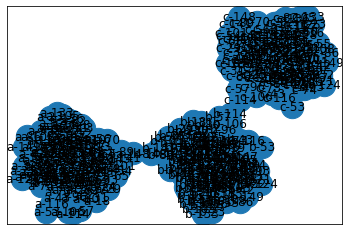

In [275]:
a = module['G']


b = nx.union(a,a, rename=('a-', 'b-'))
b.add_edge('a-148', 'b-148')

plt.figure()
nx.draw_networkx(b,with_labels=True,node_size=500)

plt.figure()
a=nx.relabel_nodes(a, { n: str(n) if n==0 else 'c-'+str(n) for n in  a.nodes })
c = nx.union(a,b)
c.add_edge('c-114','b-114')
pos=nx.kamada_kawai_layout(c)
nx.draw_networkx(c,pos=pos,with_labels=True,node_size=500)
plt.show()

In [342]:
#SINGLE NETWORK:
MC_single,sim_single,G,node_list=get_MC_Voltsweep(a,amp=2,return_sim=True)

In [343]:
MC_single

21.75494021374923

In [336]:
#DEEP NETWORKS:

sim=[None]*3
MC=[None]*3

MC_final=[]
#One Reservoir of 450 nodes:
MC[0],sim[0],G,node_list=get_MC_Voltsweep(a,amp=2,return_sim=True)
state1=getJunctionState(sim[0])

In [337]:
MC[1],sim[1],G,node_list=get_MC_Voltsweep(a,amp=2,init_state=state1,return_sim=True)
state2=getJunctionState(sim[1])

In [338]:
MC[2],sim[2],G,node_list=get_MC_Voltsweep(a,amp=2,init_state=state2,return_sim=True)

In [339]:
MC

[3.4331642904519946, 6.8239757149471725, 20.16211900825337]

In [340]:
node_list=node_list*3

In [341]:
#     node_list=n_outs#len(node_list)
dur = 1
mc=[]
for k in tqdm(range(dur, len(node_list)*dur, dur)):
    
    signal = np.hstack((sim[0].stimulus[0].signal[transient:],sim[1].stimulus[0].signal[transient:],sim[2].stimulus[0].signal[transient:]))
    wire_voltage = np.vstack((sim[0].wireVoltage[transient:],sim[1].wireVoltage[transient:],sim[2].wireVoltage[transient:]))
    T, N = wire_voltage.shape
    #     node_list = np.random.choice(range(0, N), n_outs, replace = False)
    lhs = wire_voltage[k:,node_list]
    rhs = signal[:-k]

    weight = np.linalg.lstsq(lhs, rhs, rcond = None)[0] #output weights (voltage) and input (voltage) using least squares regression
    result = np.matmul(lhs, weight)
    mc.append((np.cov(rhs, result)[0,1])**2/(np.var(signal[k:])*np.var(result)))
    
MC_final=np.sum(mc)

<ipython-input-341-a4bddaf6400a>:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for k in tqdm(range(dur, len(node_list)*dur, dur)):


In [344]:
MC_final

19.199529269797864

In [345]:
# WIDE NETWORKS:
sim_wide=[None]*3
MC_wide=[None]*3

MC_wide[0],sim_wide[0],G,node_list=get_MC_Voltsweep(a,amp=2,return_sim=True)
MC_wide[1],sim_wide[1],G,node_list=get_MC_Voltsweep(a,amp=2,return_sim=True)
MC_wide[2],sim_wide[2],G,node_list=get_MC_Voltsweep(a,amp=2,return_sim=True)

In [350]:
wire_voltage.shape

(2700, 150)

In [352]:
#     node_list=n_outs#len(node_list)
dur = 1
mc=[]
node_list=node_list*3
for k in tqdm(range(dur, len(node_list)*dur, dur)):
    signal = np.hstack((sim_wide[0].stimulus[0].signal[transient:],sim_wide[1].stimulus[0].signal[transient:],sim_wide[2].stimulus[0].signal[transient:]))
    wire_voltage = np.vstack((sim_wide[0].wireVoltage[transient:],sim_wide[1].wireVoltage[transient:],sim_wide[2].wireVoltage[transient:]))
    T, N = wire_voltage.shape
    #     node_list = np.random.choice(range(0, N), n_outs, replace = False)
    lhs = wire_voltage[k:,node_list]
    rhs = signal[:-k]

    weight = np.linalg.lstsq(lhs, rhs, rcond = None)[0] #output weights (voltage) and input (voltage) using least squares regression
    result = np.matmul(lhs, weight)
    mc.append((np.cov(rhs, result)[0,1])**2/(np.var(signal[k:])*np.var(result)))
    
MC_final_wide=np.sum(mc)

<ipython-input-352-82dd4c5ac8dd>:5: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for k in tqdm(range(dur, len(node_list)*dur, dur)):


In [353]:
MC_final_wide

15.136247259674592